In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

from util.dbconn import DbConn

In [2]:
WAREHOUSE_CONN = {
    'user': 'postgres',
    'password': 'qshOke46RvOg0',
    'host': 'localhost',
    'port': '8084',
    'dbname': 'warehouse'
}

In [3]:
postgres_conn = DbConn(WAREHOUSE_CONN).get_conn()

In [4]:
sql = """WITH order_date AS (
	SELECT 
		od.order_key,
		od.order_date,
		dd.date_id
	FROM 
		order_dim od
	LEFT JOIN date_dim dd ON
		DATE(od.order_date) = dd.full_date
),
fact_order AS (
SELECT 
	dd."year",
	dd.quarter,
	dd."month",
    dd."date",
	count(DISTINCT od.order_key) AS count_order
FROM 
	order_dim od 
LEFT JOIN order_date odt ON
	od.order_date = odt.order_date
LEFT JOIN date_dim dd ON
	odt.date_id = dd.date_id 
GROUP BY dd."year", ROLLUP(dd.quarter, dd."month", dd."date")
)
SELECT 
	*
FROM 
	fact_order fo
WHERE fo.quarter IS NOT NULL AND 
		fo."month" IS NOT NULL AND
        fo."date" IS NOT NULL;
"""

In [5]:
df = pd.read_sql(sql=sql, con=postgres_conn)

display(df.info())
display(df.describe())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   year         634 non-null    int64
 1   quarter      634 non-null    int64
 2   month        634 non-null    int64
 3   date         634 non-null    int64
 4   count_order  634 non-null    int64
dtypes: int64(5)
memory usage: 24.9 KB


None

,year,quarter,month,date,count_order
count,634.000000,634.000000,634.000000,634.000000,634.000000
mean,2017.383281,2.326498,5.938486,15.597792,156.847003
std,0.533051,1.055651,3.214452,8.768610,94.224817
min,2016.000000,1.000000,1.000000,1.000000,1.000000
25%,2017.000000,1.000000,3.000000,8.000000,96.000000
50%,2017.000000,2.000000,6.000000,15.500000,148.000000
75%,2018.000000,3.000000,8.000000,23.000000,215.750000
max,2018.000000,4.000000,12.000000,31.000000,1176.000000


,year,quarter,month,date,count_order
0,2016,3,9,4,1
1,2016,3,9,5,1
2,2016,3,9,13,1
3,2016,3,9,15,1
4,2016,4,10,2,1


In [6]:
def shift(data, n_in=1, n_out=1, dropna=True):
    """
    Arguments:
        data: Sequence of observations as DataFrame or Numpy Array.
        n_in: Number of lag observations as input.
        n_out: Number of observations as output.
        dropna: Boolean whether to drop rows with NaN values.
    Returns:
        df: Pandas DataFrame
    """
    var = range(0, data.shape[0]) if isinstance(data, np.ndarray) else \
            data.columns if isinstance(data, pd.DataFrame) else None
    
    if var is None:
        raise Exception('Expected pandas.DataFrame or numpy.ndarray got {}'.format(type(data)))
    
    df = pd.DataFrame(data)
    cols, names = [], []
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{n}(t-{i})'.format(n=v, i=i)) for v in var]
    
    for i in range(0, n_out):
        cols.append(df.shift(i))
        if i == 0:
            names += [('{n}(t)'.format(n=v)) for v in var]
        else:
            names += [('{n}(t+{i})'.format(n=v, i=i)) for v in var]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropna:
        agg.dropna(inplace=True)
    
    return agg

In [7]:
t = df.loc[:, ['count_order']]

fiturnya pakai tanggal, bulan, tahun, hari, minggu ke-,

In [8]:
t0 = shift(t, 2, 1)
t0

,count_order(t-2),count_order(t-1),count_order(t)
2,1.0,1.0,1
3,1.0,1.0,1
4,1.0,1.0,1
5,1.0,1.0,8
6,1.0,8.0,63
...,...,...,...
629,1.0,1.0,1
630,1.0,1.0,1
631,1.0,1.0,1
632,1.0,1.0,1


In [9]:
t1 = t0.copy()
t1['id'] = t1.index
t1 = t1.loc[:, ['id', 'count_order(t)']] \
        .groupby('count_order(t)', as_index=False).count()

In [10]:
t1.columns = ['count_order(t)', 'count_id']
t1

,count_order(t),count_id
0,1,19
1,3,1
2,4,4
3,5,1
4,6,2
...,...,...
267,380,1
268,391,1
269,403,1
270,499,1


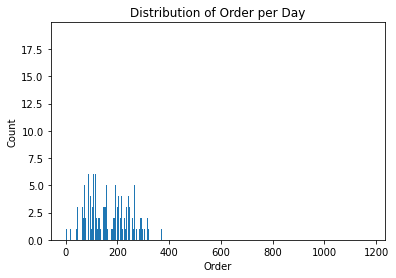

In [11]:
fig, ax = plt.subplots()

ax.bar(t1['count_order(t)'], t1['count_id'])
ax.set_title('Distribution of Order per Day')
ax.set_xlabel('Order')
ax.set_ylabel('Count')

plt.show()

In [12]:
t_ = t0[t0['count_order(t)'] < 1176]
t_

,count_order(t-2),count_order(t-1),count_order(t)
2,1.0,1.0,1
3,1.0,1.0,1
4,1.0,1.0,1
5,1.0,1.0,8
6,1.0,8.0,63
...,...,...,...
629,1.0,1.0,1
630,1.0,1.0,1
631,1.0,1.0,1
632,1.0,1.0,1


## MLP Regressor

In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import median_absolute_error, mean_absolute_error
from sklearn.model_selection import train_test_split

splitnya jangan random<br>
cek overfit

In [14]:
X = t_[['count_order(t-2)', 'count_order(t-1)']]
y = t_['count_order(t)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [15]:
mlpr = MLPRegressor(
            hidden_layer_sizes=(100,30),
            activation='relu',
            solver='lbfgs',
            learning_rate='constant',
            learning_rate_init=0.001,
            max_iter=1000)

In [16]:
mlpr.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 30), max_iter=1000, solver='lbfgs')

In [17]:
y_pred = mlpr.predict(X_test)

### Evaluation

In [18]:
med_ae = median_absolute_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [19]:
med_ae

16.79058156949563

In [20]:
mae

24.27077343734721

## Support Vector Regression

In [21]:
from sklearn.svm import LinearSVR

In [22]:
linear_svr = LinearSVR(tol=1e-4, max_iter=100000)
linear_svr.fit(X_train, y_train)

LinearSVR(max_iter=100000)

In [23]:
y_pred = linear_svr.predict(X_test)

In [24]:
med_ae = median_absolute_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [25]:
med_ae

13.780323020809135

In [26]:
mae

23.01582441286608

## SGD Regressor

In [27]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [28]:
sgdr = SGDRegressor(
            loss='squared_loss',
            penalty='l2',
            eta0=0.01,
            alpha=0.001,
            learning_rate='optimal',
            tol=1e-2,
            max_iter=100000)

pipeline = make_pipeline(StandardScaler(), sgdr)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.001, learning_rate='optimal',
                              max_iter=100000, tol=0.01))])

In [29]:
y_pred = pipeline.predict(X_test)

In [30]:
med_ae = median_absolute_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [31]:
med_ae

17.03359028854485

In [32]:
mae

25.987496215847166